<a href="https://colab.research.google.com/github/utkarsh-mishra19/pytorch/blob/main/pytorch2_img_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
!pip install opendatasets --quiet
import opendatasets as od
dataset_url = ("https://www.kaggle.com/datasets/andrewmvd/animal-faces")
od.download(dataset_url)

Skipping, found downloaded files in "./animal-faces" (use force=True to force download)


In [19]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision.transforms import transforms
from torch.utils.data import Dataset, DataLoader
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from PIL import Image


In [20]:
device = "cuda"if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [21]:
image_path = []
labels = []
for i in os.listdir("/content/animal-faces/afhq"):
  for label in os.listdir(f"/content/animal-faces/afhq/{i}"):
    for immage in os.listdir(f"/content/animal-faces/afhq/{i}/{label}"):
      image_path.append(f"/content/animal-faces/afhq/{i}/{label}/{immage}")
      labels.append(label)
data_df = pd.DataFrame(zip(image_path,labels),columns=["image_path","labels"])
data_df.head()

,image_path,labels
0,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
1,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
2,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
3,/content/animal-faces/afhq/val/wild/flickr_wil...,wild
4,/content/animal-faces/afhq/val/wild/flickr_wil...,wild


In [22]:
train = data_df.sample(frac=0.7)
test = data_df.drop(train.index)
val = test.sample(frac = 0.5)
test = test.drop(val.index)


In [23]:
label_encoder = LabelEncoder()
label_encoder.fit(data_df["labels"])

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float32),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [24]:
class CustomImageDataset(Dataset):
  def __init__(self,dataframe,transform = None):
    self.dataframe = dataframe
    self.transform = transform
    self.labels = label_encoder.transform(self.dataframe["labels"])
  def __len__(self):
    return self.dataframe.shape[0]
  def __getitem__(self,index):
    image = Image.open(self.dataframe.iloc[index,0]).convert("RGB")
    label = self.labels[index]
    if self.transform is not None:
      image = self.transform(image)
    return image, label


In [25]:
train_dataset = CustomImageDataset(train,transform)
test_dataset = CustomImageDataset(test,transform)
val_dataset = CustomImageDataset(val,transform)

In [26]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)
lr = 0.0001




In [27]:
class Net(nn.Module):
    def __init__(self):
      super().__init__()

      self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1) # First Convolution layer
      self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1) # Second Convolution layer
      self.conv3 = nn.Conv2d(64, 128, kernel_size = 3, padding = 1) # Third Convolution layer
      self.pooling = nn.MaxPool2d(2,2) # The pooling layer, we will be using the same layer after each conv2d.
      self.relu = nn.ReLU() # ReLU Activation function

      self.flatten = nn.Flatten() # Flatten and vectorize the output feature maps that somes from the final convolution layer.
      self.linear = nn.Linear((128 * 28 *28), 128) # Traditional Dense (Linear)
      self.output = nn.Linear(128, len(data_df['labels'].unique())) # Output Linear Layer


    def forward(self, x):
      x = self.conv1(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv2(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.conv3(x)
      x = self.pooling(x)
      x = self.relu(x)
      x = self.flatten(x)
      x = self.linear(x)
      x = self.output(x)

      return x

model = Net().to(device) # Create an instance of the model and move it to the GPU Device

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr)
epochs = 5

total_loss_train_plot = []
total_loss_validation_plot = []
total_acc_train_plot = []
total_acc_validation_plot = []

for epoch in range(epochs):
    total_acc_train = 0
    total_loss_train = 0
    total_loss_val = 0
    total_acc_val = 0

    # --- Training ---
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(inputs)
        train_loss = criterion(outputs, labels)
        total_loss_train += train_loss.item()

        train_loss.backward()
        optimizer.step()

        total_acc_train += (outputs.argmax(1) == labels).sum().item()

    # --- Validation ---
    model.eval()
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            val_loss = criterion(outputs, labels)
            total_loss_val += val_loss.item()

            total_acc_val += (outputs.argmax(1) == labels).sum().item()

    # --- Logging ---
    avg_train_loss = total_loss_train / len(train_loader)
    avg_val_loss = total_loss_val / len(val_loader)
    train_acc = total_acc_train / len(train_dataset) * 100
    val_acc = total_acc_val / len(val_dataset) * 100

    total_loss_train_plot.append(avg_train_loss)
    total_loss_validation_plot.append(avg_val_loss)
    total_acc_train_plot.append(train_acc)
    total_acc_validation_plot.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    print("="*25)

Epoch 1/5 | Train Loss: 0.0164, Train Acc: 99.50% | Val Loss: 0.2149, Val Acc: 95.33%
Epoch 2/5 | Train Loss: 0.0085, Train Acc: 99.77% | Val Loss: 0.1667, Val Acc: 96.20%
Epoch 3/5 | Train Loss: 0.0020, Train Acc: 99.96% | Val Loss: 0.1685, Val Acc: 95.95%
Epoch 4/5 | Train Loss: 0.0091, Train Acc: 99.73% | Val Loss: 0.2071, Val Acc: 95.41%
Epoch 5/5 | Train Loss: 0.0115, Train Acc: 99.65% | Val Loss: 0.2054, Val Acc: 95.58%


In [17]:
with torch.no_grad():
  test_acc = 0
  for inputs,labels in test_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    output = model(inputs)
    test_acc += (output.argmax(1) == labels).sum().item()

  print(f"Test Accuracy: {round((test_acc)/test_dataset.__len__() * 100, 4)}")


Test Accuracy: 96.1554


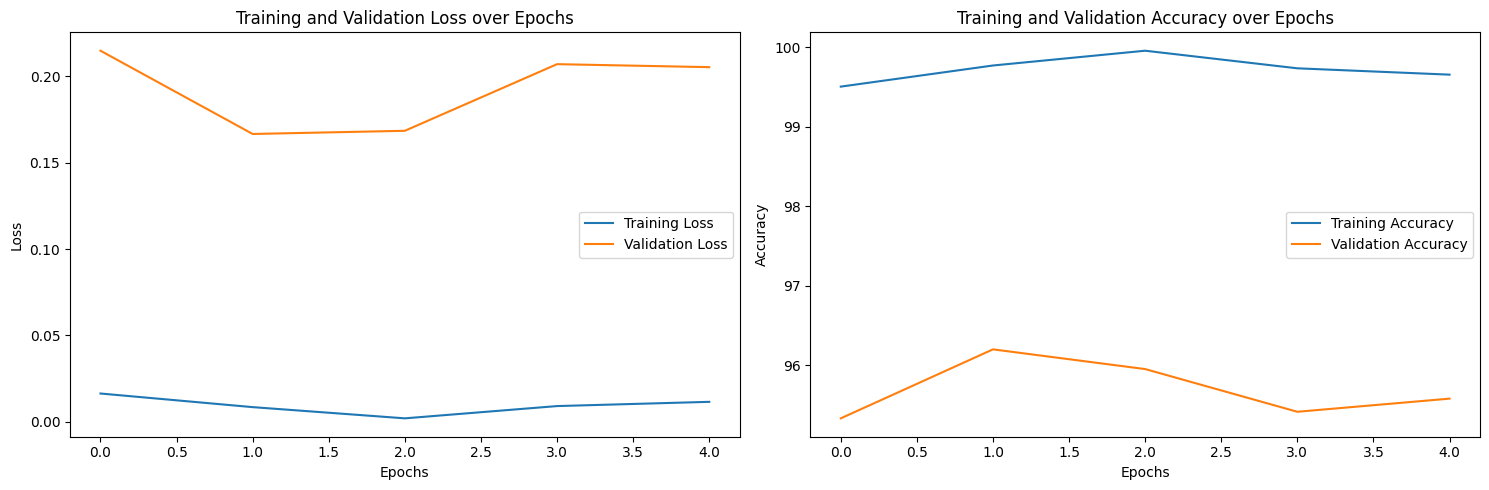

In [28]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

axs[0].plot(total_loss_train_plot, label='Training Loss')
axs[0].plot(total_loss_validation_plot, label='Validation Loss')
axs[0].set_title('Training and Validation Loss over Epochs')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
axs[0].legend()

axs[1].plot(total_acc_train_plot, label='Training Accuracy')
axs[1].plot(total_acc_validation_plot, label='Validation Accuracy')
axs[1].set_title('Training and Validation Accuracy over Epochs')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Accuracy')
axs[1].legend()

plt.tight_layout()

plt.show()

In [43]:
def predict_image(image_path):
  image = Image.open(image_path).convert('RGB')
  image = transform(image).to(device)

  output = model(image.unsqueeze(0))
  output = torch.argmax(output, axis = 1).item()
  return label_encoder.inverse_transform([output])
predict_image("/content/download.webp")

array(['dog'], dtype=object)